### Imports

In [1]:
import base64
import os
from copy import deepcopy
from io import BytesIO

from PIL import Image
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_openai import ChatOpenAI

from client import DetectionClient, SegmentationClient
from client.utils import draw_detections

BASE_URL="https://9oagrot08wqem8-8008.proxy.runpod.net/"
VLLM_BASE_URL=os.path.join(BASE_URL, "vllm/v1")
IMAGE_BASE_URL=os.path.join(BASE_URL, "image")

TEST_IMAGE=Image.open("./test.jpg")

### Multimodal VLLM Inference

In [2]:
buffered = BytesIO()
TEST_IMAGE.save(buffered, format="JPEG")
img_base64 = base64.b64encode(buffered.getvalue()).decode()

chat = ChatOpenAI(
    model="model",
    api_key="EMPTY",
    base_url=VLLM_BASE_URL,
    max_tokens=8192,
)

messages = [
    SystemMessage(content="You are a helpful assistant that can see and understand images."),
    HumanMessage(content=[
        {"type": "text", "text": "What is in this image? Explain in great detail and write a long story about it."},
        {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{img_base64}"}}
    ]),
]
for chunk in chat.stream(messages):
    print(chunk.content, end="", flush=True)

So, let's start by analyzing the image. It's a city skyline with a lot of tall buildings, reflected in a body of water. First, I need to identify the city. The prominent buildings—like the Willis Tower (formerly Sears Tower) on the left, and the Trump International Hotel and Tower on the right—suggest this is Chicago. The water is Lake Michigan, which is a key feature of Chicago's skyline.

Now, the time of day: the sky has a gradient from warm oranges and pinks near the horizon to cooler blues higher up, indicating either sunrise or sunset. The lighting on the buildings is soft, with some reflecting the warm light, so it's likely early morning or late afternoon.

Let's break down the elements:

1. **Skyline and Buildings**: The cityscape is dense with skyscrapers. The tallest one on the left is the Willis Tower (442 meters), a defining feature of Chicago. Next to it, there's the Aon Center, then the John Hancock Center, and so on. The Trump Tower is on the right, with its distinctive 

### Open Vocabulary Object Detection

{'status': 'healthy', 'device': 'cuda', 'model': 'openmmlab-community/mm_grounding_dino_large_all'}


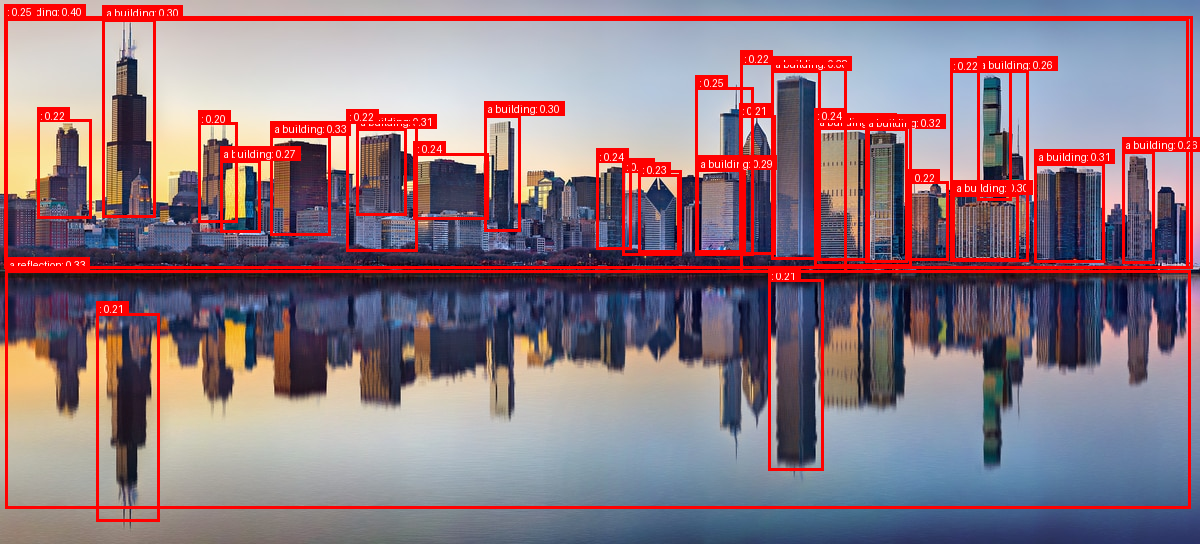

In [3]:
detection_client = DetectionClient(IMAGE_BASE_URL)

print(detection_client.health_check())
detection_results = detection_client.detect(TEST_IMAGE, ["a building", "a reflection of a building"], threshold=0.2)
draw_detections(TEST_IMAGE, detection_results)

### Image Segmentation

{'status': 'healthy', 'device': 'cuda', 'model': 'facebook/sam2.1-hiera-large'}


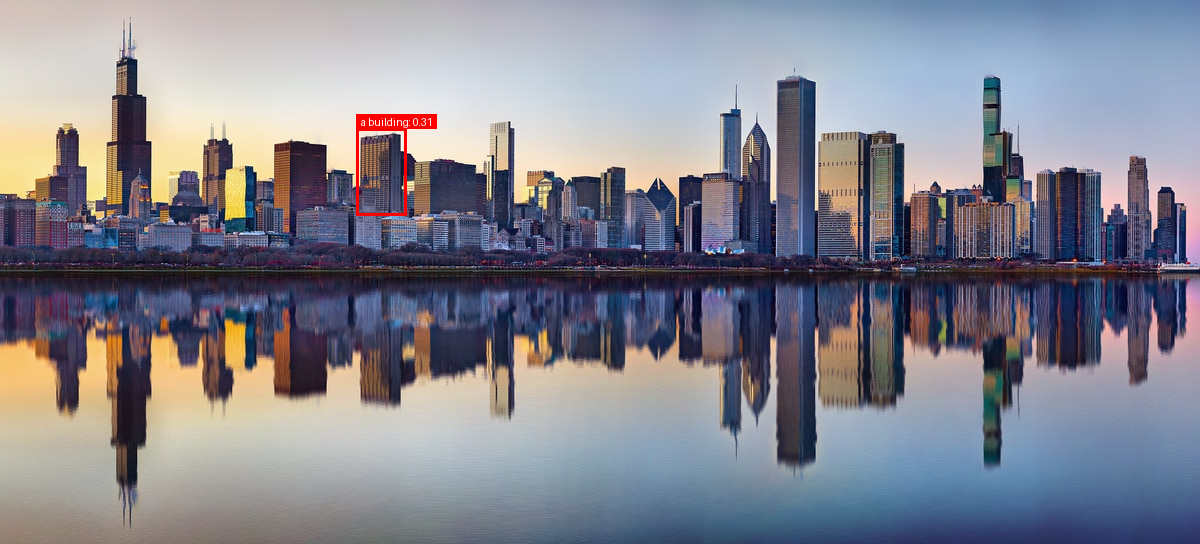

In [4]:
segmentation_client = SegmentationClient(IMAGE_BASE_URL)
print(segmentation_client.health_check())

target_idx = 3
tmp_result = deepcopy(detection_results)
tmp_result.detections[0].boxes = [tmp_result.detections[0].boxes[target_idx]]
tmp_result.detections[0].labels = [tmp_result.detections[0].labels[target_idx]]
tmp_result.detections[0].scores = [tmp_result.detections[0].scores[target_idx]]

bbox = tmp_result.detections[0].boxes[0]
center_point = [int((bbox[0]+bbox[2])//2), int((bbox[1]+bbox[3])//2)]

draw_detections(TEST_IMAGE, tmp_result)

#### Point

{'scores': [0.9164105653762817], 'shape': [1, 1, 544, 1200]}


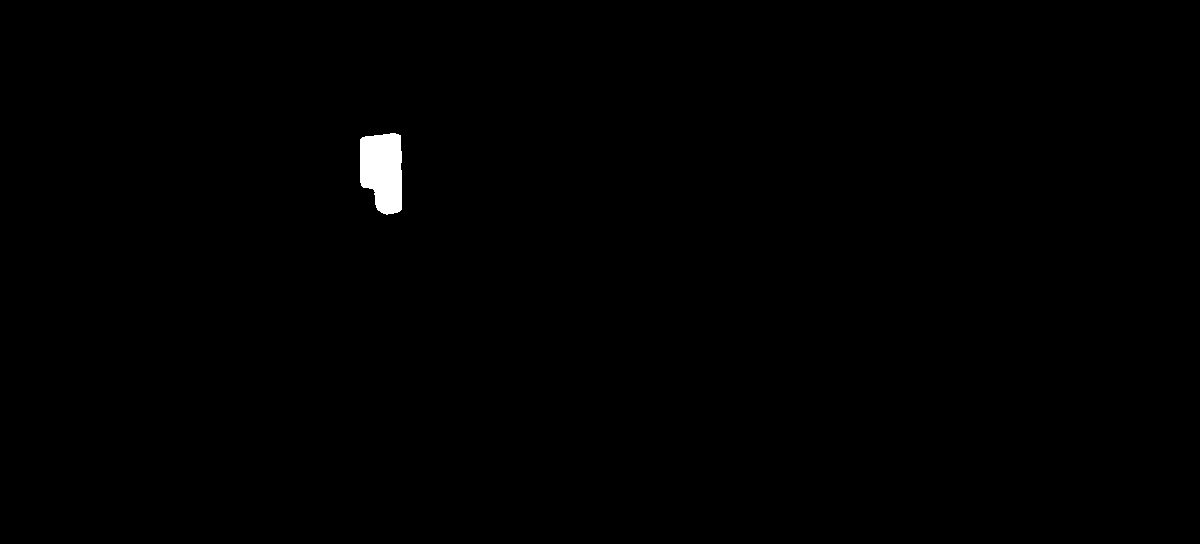

In [5]:
point_result = segmentation_client.segment_point(TEST_IMAGE, [center_point], [1])
print(point_result.get_metadata())
point_result.extract_masks()[0]

#### Box

{'scores': [0.9433553218841553], 'shape': [1, 1, 544, 1200]}


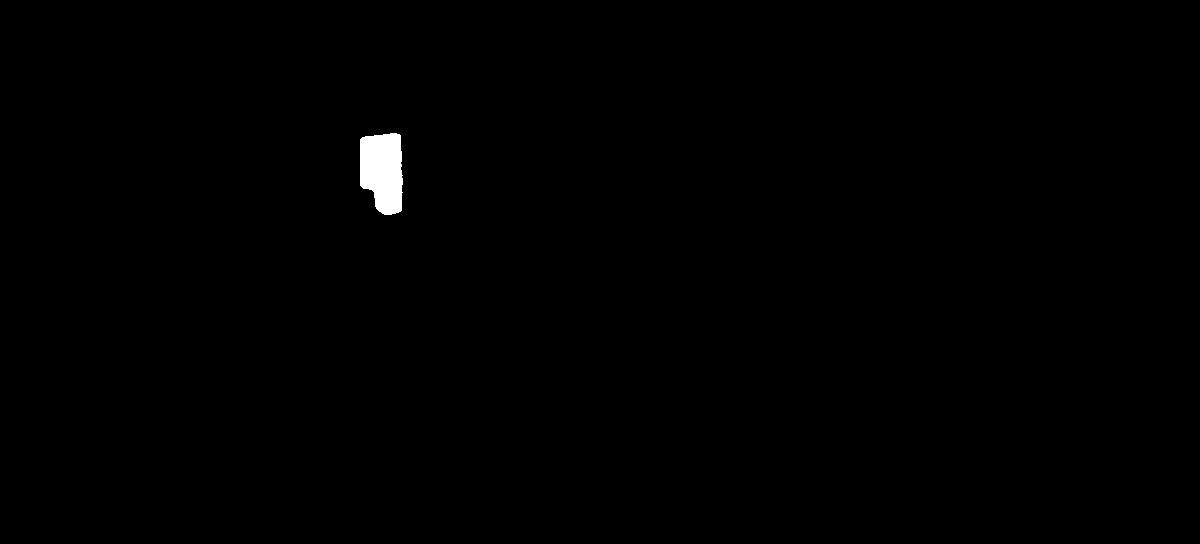

In [6]:
box_result = segmentation_client.segment_box(TEST_IMAGE, list(map(int, bbox)))
print(box_result.get_metadata())
box_result.extract_masks()[0]

#### Combined

{'scores': [0.9403718709945679], 'shape': [1, 1, 544, 1200]}


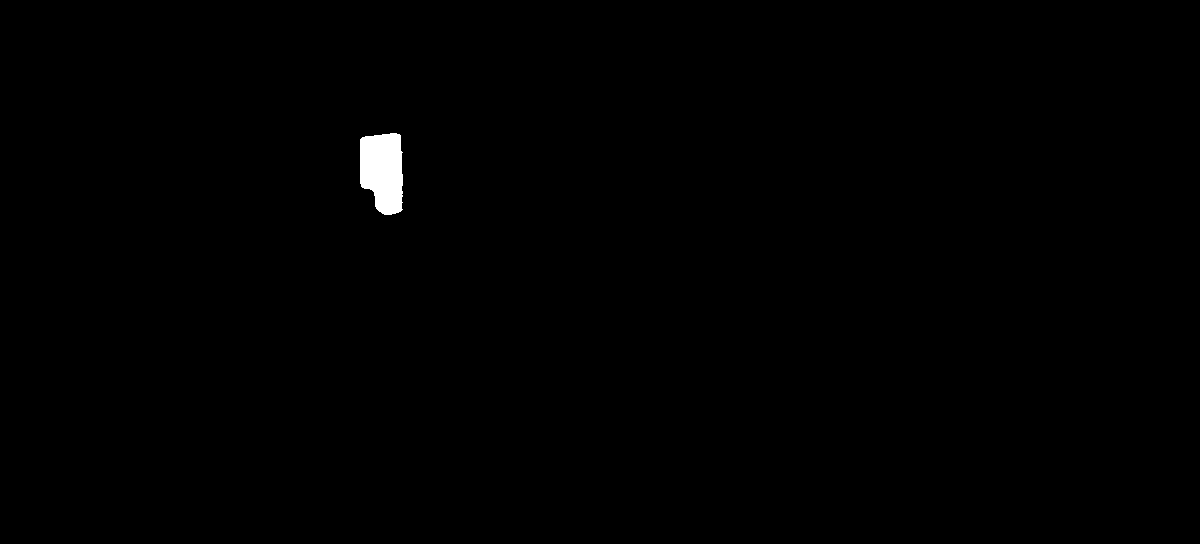

In [7]:
combined_result = segmentation_client.segment_combined(TEST_IMAGE, [center_point], [1], list(map(int, bbox)))
print(combined_result.get_metadata())
combined_result.extract_masks()[0]